In [1]:
from Bio import SeqIO
import primer3
import numpy as np
import sys
import drawSvg as draw
from IPython.display import display

In [2]:
class Primer():
    """
    Class to hold all information regarding a specific primer.
    
    Args:
    - seq (str) - string containing the primer sequence to be used
    - dna_conc (float) - concentration (nM) of oligo to use for Tm analysis, default is 250
    - mv_conc (float) - concentration (mM) of monovalent cations to use for Tm analysis, default is 50
    - dv_conc (float) - concentration (mM) of divalent cations to use for Tm analysis, default is 0
    - dntp_conc (float) - concentration (mM) of dNTPs to use for Tm analysis, default is 0
    """
    
    def __init__(self, seq, dna_conc=250, mv_conc=50, dv_conc=0, dntp_conc=0):
        # Convert the sequence to uppercase
        seq = seq.upper()
        
        # Set the sequence to an instance variable
        self.seq = seq
        
        # Set the length variable
        self.length = len(seq)
        
        # Set the standard IDT OligoAnalyzer settings for analysis by primer3
        self.thermo_settings = primer3.thermoanalysis.ThermoAnalysis(dna_conc, mv_conc, dv_conc, dntp_conc)
        
        # Get the Tm of the oligo
        self.Tm = self.thermo_settings.calcTm(self.seq)
        
        # Get hairpin and homodimer properties
        self.hairpin()
        self.homodimer()
        
    def hairpin(self):
        """
        Calculate hairpin properties of the oligo sequence.
        """
        hairpin_result = self.thermo_settings.calcHairpin(self.seq)
        self.hairpin = hairpin_result.structure_found
        self.hairpin_Tm = hairpin_result.tm
        
    def homodimer(self):
        """
        Calculate homodimer properties of the oligo sequence.
        """
        homodimer_result = self.thermo_settings.calcHomodimer(self.seq)
        self.homodimer = homodimer_result.structure_found
        self.homodimer_Tm = homodimer_result.tm
        
    def rc(self):
        """
        Get the reverse complement of the primer sequence.
        """
        comp = {
            'A': 'T',
            'C': 'G',
            'G': 'C',
            'T': 'A'
        }
        
        self.seq = "".join([comp[nt] for nt in self.seq[::-1]])
        
    def report(self):
        """
        Return the details of a given primer.
        """
        
        details = OrderedDict({
            'length': len(self.seq),
            'Tm': round(self.Tm, 2),
            'start': self.start,
            'end': self.end,
            'hairpin_Tm': round(self.hairpin_Tm, 2),
            'homodimer_Tm': round(self.homodimer_Tm, 2)
        })
        
        return details
    
    def __repr__(self):
        return 'Seq: {}; Tm: {:.2f}'.format(self.seq, self.Tm)
    
    def __str__(self):
        return self.__repr__()

In [3]:
class Oligo():
    """
    Class to hold all information regarding a specific oligo in a REDI library.
    
    Args:
    - seq (str) - string containing the primer sequence to be used
    - dna_conc (float) - concentration (nM) of oligo to use for Tm analysis, default is 250
    - mv_conc (float) - concentration (mM) of monovalent cations to use for Tm analysis, default is 50
    - dv_conc (float) - concentration (mM) of divalent cations to use for Tm analysis, default is 0
    - dntp_conc (float) - concentration (mM) of dNTPs to use for Tm analysis, default is 0
    """
    
    def __init__(self, template_seq, upstream_primer, downstream_primer):
        # Define upstream and downstream primers
        self.upstream_primer = upstream_primer
        self.downstream_primer = downstream_primer
        
        # Define start and end sites, as well as the sequence of the oligo
        self.start = self.upstream_primer.start
        self.end = self.downstream_primer.end
        self.seq = template_seq[self.start:self.end]
        
        # Define the window of interest for each oligo
        self.window_start = self.upstream_primer.end
        self.window_end = self.downstream_primer.start
        self.window_seq = template_seq[self.window_start:self.window_end]
        
    def __repr__(self):
        return '<Oligo ({}:{}-{}:{}) F: {:.2f}C, R: {:.2f}C>'.format(self.start, self.window_start,
                                                                     self.window_end, self.end, self.upstream_primer.Tm,
                                                                     self.downstream_primer.Tm)
    
    def __str__(self):
        return self.__repr__()

In [4]:
class LibDiagram():
    """
    Class to draw SVG library diagrams.
    
    Args:
    - lib (Library) - Library object from which to draw potential library of interest
    - lib_index (int) - index of library to draw
    - width (int) - Width of the diagram in pixels
    - height (int) - Height of the diagram in pixels
    """
    
    def __init__(self, lib, lib_index, width = 400, height = 200):
        self.lib = lib
        self.oligos = lib.libraries[lib_index]
        
        # Calculate DNA draw height and buffer distance
        self.dna_h = height / (1.1*(len(self.oligos)+1) - 0.1)
        self.buffer = 0.1 * self.dna_h
        
        self.width = width
        self.height = height
        
        # Draw the diagram
        self.draw_background()
        self.draw_template()
        self.draw_lib()
        
    def scale_x(self, nt_width):
        """
        Convert nucleotide scale to pixel scale.
        
        Args:
        - nt_width (int) - Nucleotide width to scale to pixels
        
        Returns:
        - Pixel width of the object of interest
        """
        
        # Perform conversion
        construct_length = len(self.lib.construct)
        nt_px = construct_length / self.width
        return (nt_width / nt_px)
    
    def scale_y(self, obj_index):
        """
        Convert object index to pixel scale.
        
        Args:
        - obj_index (int) - Object number in diagram (determines vertical position)
        
        Returns:
        - Pixel y-displacement of the object of interest
        """
        
        # Offset the object index by 1 to account for the template diagram
        offset = obj_index + 1
        y_offset = (offset * self.dna_h) + (self.buffer * offset)
        return(y_offset)
        
    def draw_background(self):
        """
        Draw the blank canvas.
        """
        
        # Create canvas
        self.d = draw.Drawing(self.width, self.height)

    def draw_template(self):
        """
        Draw the template strand, with the coding sequence highlighted in blue.
        """
        
        # Draw template
        self.d.append(draw.Rectangle(0, 0, self.scale_x(len(self.lib.construct)),
                                     self.dna_h, fill='#ADD8E6'))
        self.d.append(draw.Rectangle(self.scale_x(self.lib.start), 0,
                                     self.scale_x(len(self.lib.roi)), self.dna_h, fill='#0000CC'))
        
    def draw_oligo(self, oligo, y_offset):
        """
        Draw an individual oligo.
        """
        
        # Draw the primers
        primer1 = draw.Rectangle(self.scale_x(oligo.start), y_offset,
                                 self.scale_x(oligo.window_start - oligo.start), self.dna_h, fill='#FFA500')
        primer2 = draw.Rectangle(self.scale_x(oligo.window_end), y_offset,
                                 self.scale_x(oligo.end - oligo.window_end), self.dna_h, fill='#FFA500')
        self.d.append(primer1)
        self.d.append(primer2)
        
        # Draw spanning oligo
        if oligo.window_start < self.lib.start and oligo.window_end > self.lib.end:
            window1 = draw.Rectangle(self.scale_x(oligo.window_start), y_offset,
                                     self.scale_x(self.lib.start - oligo.window_start), self.dna_h, fill='#ADD8E6')
            window2 = draw.Rectangle(self.scale_x(self.lib.start), y_offset,
                                     self.scale_x(self.lib.end - self.lib.start), self.dna_h, fill='#0000CC')
            window3 = draw.Rectangle(self.scale_x(self.lib.end), y_offset,
                                     self.scale_x(oligo.window_end - self.lib.end), self.dna_h, fill='#ADD8E6')
            self.d.append(window1)
            self.d.append(window2)
            self.d.append(window3)
            
        # Draw upstream oligo
        elif oligo.window_start < self.lib.start:
            window1 = draw.Rectangle(self.scale_x(oligo.window_start), y_offset,
                                     self.scale_x(self.lib.start - oligo.window_start), self.dna_h, fill='#ADD8E6')
            window2 = draw.Rectangle(self.scale_x(self.lib.start), y_offset,
                                     self.scale_x(oligo.window_end - self.lib.start), self.dna_h, fill='#0000CC')
            self.d.append(window1)
            self.d.append(window2)
            
        # Draw downstream oligo 
        elif oligo.window_end > self.lib.end:
            window1 = draw.Rectangle(self.scale_x(oligo.window_start), y_offset,
                                     self.scale_x(self.lib.end - oligo.window_start), self.dna_h, fill='#0000CC')
            window2 = draw.Rectangle(self.scale_x(self.lib.end), y_offset,
                                     self.scale_x(oligo.window_end - self.lib.end), self.dna_h, fill='#ADD8E6')
            self.d.append(window1)
            self.d.append(window2)
            
        # Draw internal oligo
        else:
            window = draw.Rectangle(self.scale_x(oligo.window_start), y_offset,
                                    self.scale_x(oligo.window_end - oligo.window_start), self.dna_h, fill='#0000CC')
            self.d.append(window)
       
    def draw_lib(self):
        """
        Draw all of the oligos in the library of interest.
        """
        
        # Loop through and draw oligos
        for i, oligo in enumerate(self.oligos):
            self.draw_oligo(oligo, self.scale_y(i))
        
    def plot(self):
        """
        Display the oligo plot in a Jupyter notebook.
        """
        
        display(self.d)

In [5]:
class Library():
    """
    Class to manage design and optimization of oligo tiling libraries.
    
    Args:
    - fasta (str) - Path to input fasta file
    - start (int) - Starting position of the region of interest (inclusive)
    - end (int) - End position of the region of interest (exclusive)
    - oligo_size (int) - Length, in basepairs, of synthesized oligos
    - primer_min_length (int) - Minimum primer length (default = 16)
    - primer_max_length (int) - Maximum primer length (default = 30)
    - primer_min_tm (float) - Minimum primer Tm (default = 58)
    - primer_max_tm (float) - Maximum primer Tm (default = 62)
    - primer_target_tm (float) - Target primer Tm (default = 60)
    """
    
    def __init__(self, fasta, start, end, oligo_size, primer_min_length=16, primer_max_length=30,
                 primer_min_tm=58, primer_max_tm=62, primer_target_tm=60, hairpin_tolerance=10,
                 homodimer_tolerance=10):
        
        # Define instance variables
        self.start = start
        self.end = end
        self.primer_min_length = primer_min_length
        self.primer_max_length = primer_max_length
        self.primer_min_tm = primer_min_tm
        self.primer_max_tm = primer_max_tm
        self.primer_target_tm = primer_target_tm
        self.oligo_size = oligo_size
        self.hairpin_tolerance = hairpin_tolerance
        self.homodimer_tolerance = homodimer_tolerance
        
        # Read in the data
        self.construct = list(SeqIO.parse(fasta, 'fasta'))[0]
        
        # Extract the region of interest
        self.roi = self.construct[start:end]
        
        # Define possible breakpoints (all codon boundaries plus nucleotides beyond the end of the ROI)
        self.breakpoints = [x + self.start for x in range(end - start) if x % 3 == 0] + [i for i in range(self.end, len(self.construct))]
        
        # Make a list of the oligos
        self.libraries = []

    def make_primer_with_tm(self, start_pos, rc=False):
        """
        Design a primer with the target Tm.
        
        Args:
        - start_pos (int) - Starting position of the primer
        
        Returns:
        - Primer object with properties closest to desired Tm
        """
        
        # Get the construct sequence
        seq = self.construct
        
        # Set the initial Tm to 0 and the nucleotide distance to 0
        primer_tm = -np.inf
        n = self.primer_min_length
        current_diff = abs(primer_tm - self.primer_target_tm)
        
        # Make empty lists
        primers = []
        primer_tms = []

        # Keep extending until the target Tm threshold is reached
        while n <= self.primer_max_length:

            # Add a nucleotide in length
            n += 1

            # Get the primer
            primer_end = start_pos + n
            primer_site = str(seq[start_pos:primer_end].seq)
            primer = Primer(primer_site)
            primers.append(primer)

            # Reverse complement if need reverse primer
            if rc:
                primer.rc()

            # Add start and end position data
            primer.start = start_pos
            primer.end = primer_end

            # Extract the Tm
            primer_tm = primer.Tm
            primer_tms.append((primer_tm - self.primer_target_tm)**2)
                
        return(primers[np.argmin(primer_tms)])
        
    def get_first_oligos(self):
        """
        Get the starting point oligos for the library.
        
        Returns:
        - List of potential first oligos to construct a library around
        """
        
        # Initialize empty list of valid starting oligos
        start_oligos = []
        
        # Loop through potential breakpoints
        for bp in self.breakpoints[1:]:
            
            # Define the end of the window at the breakpoint
            window_end = bp
            
            # Design the downstream primer
            downstream_primer = self.make_primer_with_tm(window_end, rc=True)
            
            # Downstream primer defines the oligo position
            oligo_end = downstream_primer.end
            oligo_start = oligo_end - self.oligo_size
            
            # Make sure the oligo does not start before the beginning of the construct
            if oligo_start < 0:
                continue
                
            # Define the upstream primer
            upstream_primer = self.make_primer_with_tm(oligo_start, rc = True)
            
            # Make sure both primers are of vald length
            up_valid_length = self.primer_min_length <= upstream_primer.length <= self.primer_max_length
            dp_valid_length = self.primer_min_length <= upstream_primer.length <= self.primer_max_length
            
            if not up_valid_length or not dp_valid_length:
                continue
            
            # Stop search once the primers encroach on the start of the ROI
            if upstream_primer.end > self.start:
                break
              
            # If everything checks out, define an oligo and add it to the list 
            if self.primer_in_tm_range(upstream_primer) and self.primer_in_tm_range(downstream_primer):
                oligo = Oligo(self.construct, upstream_primer, downstream_primer)
                start_oligos.append(oligo)
                
        return start_oligos
    
    def define_primers(self, oligo_start, window_start, window_end, oligo_end):
        """
        Defines primer sites based on oligo and window sizes.
        
        Args:
        - oligo_start (int) - Start poition of the oligo
        - window_start (int) - Start poition of the window
        - window_end (int) - End poition of the window
        - oligo_end (int) - End poition of the oligo
        
        Returns:
        - Tuple of Primer objects corresponding to upstream and downstream primers
        """
        
        # Define the upstream primer
        upstream_primer = Primer(str(self.construct[oligo_start:window_start].seq))
        upstream_primer.start = oligo_start
        upstream_primer.end = window_start
        
        # Define the downstream primer
        downstream_primer = Primer(str(self.construct[window_end:oligo_end].seq))
        downstream_primer.start = window_end
        downstream_primer.end = oligo_end
        
        return upstream_primer, downstream_primer
    
    def primer_in_tm_range(self, primer):
        """
        Check if primer Tm is in desired range.
        
        Args:
        - primer (Primer) - Primer to test
        
        Returns:
        - Boolean value whether primer is in desired Tm range
        """
        return self.primer_min_tm <= primer.Tm <= self.primer_max_tm

    def create_next_oligo(self, oligos):
        """
        Create the next oligo in a path and set add all valid libraries to the `libraries` instance variable.
        
        Args:
        - oligos (list) - List of oligos corresponding to path up to current point
        """
        # Get the last oligo
        last_oligo = oligos[-1]
        
        # Define the current window start
        window_start = last_oligo.window_end
        
        # Loop through all of the breakpoints
        for window_end in self.breakpoints:
            
            # Get the window parameters
            window_size = window_end - window_start
            valid_window = window_size > 0 
            valid_size = self.primer_min_length <= ((self.oligo_size - window_size) / 2) <= self.primer_max_length
            
            # Get the oligo parameters
            oligo_end = window_end + self.primer_min_length
            oligo_start = oligo_end - self.oligo_size
            
            # Check if the window is valid
            if valid_window and valid_size:
                
                # Get the length of the upstream primer
                up_length = window_start - oligo_start
            
                # Perform sliding window search until upstream primer is too short
                while up_length >= self.primer_min_length:
                    
                    # Define the primers
                    upstream_primer, downstream_primer = self.define_primers(oligo_start, window_start, window_end, oligo_end)
                    
                    # Make sure primers are valid length
                    up_valid = self.primer_min_length <= window_start - oligo_start <= self.primer_max_length
                    dp_valid = self.primer_min_length <= oligo_end - window_end <= self.primer_max_length

                    # Check if primers are in the appropriate Tm range
                    if self.primer_in_tm_range(upstream_primer) and self.primer_in_tm_range(downstream_primer) and up_valid and dp_valid:
                        
                        # Define the oligo and add it to the path
                        oligo = Oligo(self.construct, upstream_primer, downstream_primer)
                        path = oligos.copy()
                        path.append(oligo)

                        # Add valid path to list if it is the last one, otherwise, continue search along current path
                        if window_end > self.end:
                            self.libraries.append(path)
                            print("\tValid libraries found:", len(self.libraries))
                        else:
                            self.create_next_oligo(path)

                    # Continue sliding window search
                    oligo_start += 1
                    oligo_end += 1

                    up_length = window_start - oligo_start
                    
                    
    def design_lib(self):
        """
        Find all valid libraries for the construct.
        """
        
        # Find all valid first oligos
        first_oligos = self.get_first_oligos()
        
        # Get all complete paths
        for i, starting_point in enumerate(first_oligos):
            print("Starting oligo {} of {}".format(i + 1, len(first_oligos)))
            oligos = [starting_point]
            self.create_next_oligo(oligos)
            
    def score_libs(self, gc_ends=1, gc_comp=2, tm=1, hairpin_tm=0.1, homodimer_tm=0.1, num_oligos=None):
        """
        Score all of the libraries, find the best library, and save as the
        `best_lib` and `best_lib_index` instance variables.
        
        Args:
        - gc_ends (float) - Multiplier for GC end score (default = 1)
        - gc_comp (float) - Multiplier for penalty for devaiting from target
            GC content of 0.5 (default = 2)
        - tm (float) - Multipleir for penalty for devaiting from target primer
            Tm (default = 1)
        - hairpin_tm (float) - Multiplier for each degree below minimum hairpin
            tolerance (default = .1)
        - homodimer_tm (float) - Multiplier for each degree below minimum
            homodimer tolerance (default = .1)
        - num_oligos (str) Set to "min" to search only the libraries with the
            minimum oligo count (default = None)
        """
        
        # Set the initial best library score to infinity 
        best_lib_score = -np.inf
        
        # Keep track of the minimum length library
        min_length = np.inf
        
        # Loop through all valid libraries
        for i, lib in enumerate(self.libraries):
            
            # Get library length
            lib_length = len(lib)
            
            # Loop through all of the oligos in the library
            for oligo in lib:
                
                # Start with a score of 0
                lib_score = 0
                
                # Loop through all of the primers in the oligo
                for primer in [oligo.upstream_primer, oligo.downstream_primer]:
                    
                    # Calculate a score for each primer and add it to the oligo score
                    gc_end_score = gc_ends * (float(primer.seq.startswith(('C', 'G'))) +
                                              float(primer.seq.endswith(('C', 'G'))))
                    gc_comp_score = -gc_comp * abs((primer.seq.count('G') + primer.seq.count('C') / len(primer.seq))- 0.5)
                    tm_mean_score = -tm * abs(primer.Tm - self.primer_target_tm)
                    hairpin_tm_score = hairpin_tm * abs(self.hairpin_tolerance - primer.hairpin_Tm)
                    homodimer_tm_score = homodimer_tm * abs(self.homodimer_tolerance - primer.homodimer_Tm)

                    lib_score += gc_end_score + gc_comp_score + tm_mean_score + hairpin_tm_score + homodimer_tm_score

            # Normalize by library length
            lib_score /= lib_length
            
            # Handle instance where only libraries of minimum length should be considered
            if num_oligos == "min" and lib_length < min_length:
                best_lib_score = -np.inf
                min_length = lib_length
            
            # Reset best score if this lib is the best
            if lib_score > best_lib_score:
                best_lib_score = lib_score
                self.best_lib_index = i
                self.best_lib = lib
             
    def plot_best_lib(self):
        """
        Plot the library found as the best.
        """
        if not hasattr(self, "best_lib_index"):
            print("Scoring libraries using default parameters...")
            self.score_libs()
        
        LibDiagram(self, self.best_lib_index).plot()

In [19]:
lib = Library('myc_dhfr_ivtt.fa', 155, 629, 230, primer_min_tm=59, primer_max_tm=61, primer_target_tm=60)
lib.design_lib()
lib.score_libs()

Starting oligo 1 of 19
Starting oligo 2 of 19
Starting oligo 3 of 19
Starting oligo 4 of 19
Starting oligo 5 of 19
	Valid libraries found: 1
	Valid libraries found: 2
	Valid libraries found: 3
	Valid libraries found: 4
Starting oligo 6 of 19
Starting oligo 7 of 19
Starting oligo 8 of 19
Starting oligo 9 of 19
Starting oligo 10 of 19
Starting oligo 11 of 19
Starting oligo 12 of 19
	Valid libraries found: 5
	Valid libraries found: 6
	Valid libraries found: 7
	Valid libraries found: 8
	Valid libraries found: 9
	Valid libraries found: 10
	Valid libraries found: 11
	Valid libraries found: 12
Starting oligo 13 of 19
Starting oligo 14 of 19
	Valid libraries found: 13
	Valid libraries found: 14
Starting oligo 15 of 19
Starting oligo 16 of 19
Starting oligo 17 of 19
Starting oligo 18 of 19
Starting oligo 19 of 19


In [134]:
lib = Library('pafa_ivtt.fa', 231, 1810, 230, primer_min_tm=54.0, primer_max_tm=55.9, primer_target_tm=55)
lib.design_lib()
lib.score_libs()

Starting oligo 1 of 23
Starting oligo 2 of 23
Starting oligo 3 of 23
Starting oligo 4 of 23
	Valid libraries found: 1
	Valid libraries found: 2
	Valid libraries found: 3
	Valid libraries found: 4
	Valid libraries found: 5
	Valid libraries found: 6
	Valid libraries found: 7
	Valid libraries found: 8
	Valid libraries found: 9
	Valid libraries found: 10
	Valid libraries found: 11
	Valid libraries found: 12
	Valid libraries found: 13
	Valid libraries found: 14
	Valid libraries found: 15
	Valid libraries found: 16
	Valid libraries found: 17
	Valid libraries found: 18
	Valid libraries found: 19
	Valid libraries found: 20
	Valid libraries found: 21
	Valid libraries found: 22
	Valid libraries found: 23
	Valid libraries found: 24
	Valid libraries found: 25
	Valid libraries found: 26
	Valid libraries found: 27
	Valid libraries found: 28
	Valid libraries found: 29
	Valid libraries found: 30
	Valid libraries found: 31
	Valid libraries found: 32
	Valid libraries found: 33
	Valid libraries found: 34

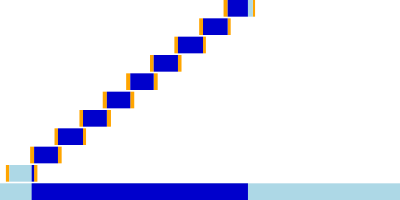

In [137]:
lib.plot_best_lib()

In [135]:
import copy
from Bio.Data import CodonTable

codon_table = CodonTable.unambiguous_dna_by_name["Standard"]

class MutantLib():
    """
    Class to handle REDI mutant generation from a predesigned library. This class
    allows for both codon change point and insertion mutations.

    Args:
    - lib (Library) - Library object to use as the basis for mutant library generation
    - output_prefix (str) - Prefix for all output files
    - offset (int) - Numeric offset for starting position of window of interest
    - index (str/int) - Either `best` or an index to use for the mutant library design
    """
    
    # Back-translation table with complete codon list, unlike BioPython
    back_trans_tab = {
            'A': ('GCT', 'GCC', 'GCA', 'GCG'),
            'C': ('TGT', 'TGC'),
            'D': ('GAT', 'GAC'),
            'E': ('GAA', 'GAG'),
            'F': ('TTT', 'TTC'),
            'G': ('GGT', 'GGC', 'GGA', 'GGG'),
            'I': ('ATT', 'ATC', 'ATA'),
            'H': ('CAT', 'CAC'),
            'K': ('AAA', 'AAG'),
            'L': ('TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'),
            'M': ('ATG',),
            'N': ('AAT', 'AAC'),
            'P': ('CCT', 'CCC', 'CCA', 'CCG'),
            'Q': ('CAA', 'CAG'),
            'R': ('CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'),
            'S': ('TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'),
            'T': ('ACT', 'ACC', 'ACA', 'ACG'),
            'V': ('GTT', 'GTC', 'GTA', 'GTG'),
            'W': ('TGG',),
            'Y': ('TAT', 'TAC'),
            '*': ('TAA', 'TAG', 'TGA'),
    }
    
    def __init__(self, lib, output_prefix, offset=0, idx="best"):
        
        # Set instance variables
        self.lib = lib
        self.output_prefix = output_prefix
        self.offset = offset
        
        # Use the best library
        if idx == 'best':
            self.target_lib = self.lib.best_lib
            
        # Grab other index, or raise exception if invalid index
        elif isinstance(idx, int):
            self.target_lib[idx]
        else:
            raise TypeError('Improperly formatted target library index, {}. Must be `best` or of type <int>.'.format(idx))
        
    def format_primer(self, primer, protein_name, oligo_id, upstream, internal):
        """
        Format the BioPython sequence object containing a primer with the proper name.
        
        Args:
        - primer (Primer) - Primer to name
        - protein_name (str) - Name of the protein that the primer targets
        - oligo_id (int) - Index of the oligo to which the primer is complementary
        - upstream (bool) - Indicator expressing whether primer is upstream
        - internal (bool) - Indicator expressing whether primer is directed internal
            with respect to the oligo
        """
        
        if upstream:
            location = "u"
        else:
            location = "d"

        if internal:
            direction = "i"
        else:
            direction = "e"

        primer.name = "{}_o{}_{}_{}".format(protein_name, oligo_id, location, direction)
        primer.description = ""
        
    def export_primers(self):
        """
        Export all of the primers in the given library to a CSV file for easy ordering.
        """
        
        # Open the output file
        with open(self.output_prefix + "_primers.csv", "w") as primer_file:
            
            # Loop through all of the oligos in the target library
            for idx, oligo in enumerate(self.target_lib):
                
                # 1-index the primers/oligos
                idx += 1
                upstream_primer = oligo.upstream_primer
                downstream_primer = oligo.downstream_primer

                # Add the homology tails to the upstream internal primer
                ui_start = upstream_primer.end - 60
                ui_start = ui_start if ui_start >= 0 else 0
                
                # Add the homology tails to the upstream internal primer
                di_end = downstream_primer.start + 60
                di_end = di_end if di_end <= len(lib.construct.seq) else len(lib.construct.seq)
                
                # Get the sequences of the internal primers with the homology tails
                upstream_internal = lib.construct[ui_start:upstream_primer.end]
                downstream_internal = lib.construct[downstream_primer.start:di_end].reverse_complement()

                # Get the protein name
                protein_name = lib.construct.name

                # Format the names of the internal primers
                self.format_primer(upstream_internal, protein_name, idx, True, True)
                self.format_primer(downstream_internal, protein_name, idx, False, True)

                # Get the sequences of the external primers
                upstream_external = lib.construct[upstream_primer.start:upstream_primer.end].reverse_complement()
                downstream_external = lib.construct[downstream_primer.start:downstream_primer.end]

                # Format the names of the external primers
                self.format_primer(upstream_external, protein_name, idx, True, False)
                self.format_primer(downstream_external, protein_name, idx, False, False)

                # Make a list of all the primers
                primers = [upstream_internal, downstream_internal, upstream_external, downstream_external]

                # Write the primers to the output file
                for primer in primers:
                    primer_file.write("{},{}\n".format(primer.name, str(primer.seq)))
            
    def annotate_codons(self):
        """
        Make a dictionary of all useful codon information.
        """
        
        # Get the breakpoints for all valid codons
        breaks = [x + self.lib.start for x in range(self.lib.end - self.lib.start) if x % 3 == 0]
        
        # Starting point is the first breakpoint
        start = breaks[0]
        
        # Initialize an empty dictionary to hold all the information
        codons = {}
        
        # Loop through the remaining brakpoints
        for idx, breakpoint in enumerate(breaks[1:]):
            
            if self.offset > 0:
                codon_idx = idx + offset
            else:
                codon_idx + 1
            
            # Find the oligo that contains the codon defined by `start` and `breakpoint`
            for oligo_idx, oligo in enumerate(self.target_lib):
                if start >= oligo.window_start and breakpoint <= oligo.window_end:
                    break
                    
            # Extract all useful information and 1-index the codons in the dictionary
            codons[codon_idx] = {'start': start,
                                 'end': breakpoint,
                                 'oligo': oligo_idx,
                                 'in_oligo_start': start - oligo.start,
                                 'in_oligo_end': breakpoint - oligo.start,
                                 'codon': str(oligo.seq[start - oligo.start:breakpoint - oligo.start].seq),
                                 'residue': str(oligo.seq[start - oligo.start:breakpoint - oligo.start].translate().seq)}
            
            # Define the start of the next codon
            start = breakpoint
        
        # Set the `codons` instance variable
        self.codons = codons
        
    def syn_mutate(self, position, oligo, insert=False):
        """
        Place synonymous mutations in the oligo of interest to aid in long-read sequencing-based
        mutatant verification.
        
        Args:
        - position (int) - Position of the initial mutation of interest
        - oligo (str) - Sequence of oligo containing the position of interest
        - insert (bool) - Indicator specifying whether mutation is an insertion or point mutation
        """
        
        # Synonymous mutation is not yet successful
        syn_success = False
        
        # Get info about the position of interest
        poi = self.codons[position]
        
        # Change the synonymous mutation possible sites if mutation is an insert
        if insert:
            pos_list = [0, -1, 1, -2, 2, -3, 3]
        else:
            pos_list = [-1, 1, -2, 2, -3, 3]

        # Serach the possible positions for syn site
        for syn_pos in [position + i for i in pos_list]:
            
            # Get the synonymous position
            if syn_pos in list(self.codons.keys()):
                syn_codon = self.codons[syn_pos]

                # Make sure the POI and syn site are on the same oligo
                if syn_codon['oligo'] != poi['oligo']:
                    continue

                # Get a list of synonymous codons
                back_list = self.back_trans_tab[syn_codon['residue']]

                # Skip if tryptophan or methionine
                if len(back_list) < 2:
                    continue

                # Get the new codon
                new_syn_codon = [codon for codon in back_list if codon != syn_codon['codon']][0]

                # Get the new sequence of the oligo
                oligo = oligo[:syn_codon['in_oligo_start']] + new_syn_codon + oligo[syn_codon['in_oligo_end']:]

                # Indicate that the synonymous mutation process has been successful
                syn_success = True

                # Break the cycle, man
                break

        # Raise an error if the process was not successful
        if not syn_success:
            raise Exception('Connot find valid position for synonymous mutation within +/-3 codon window for position {}.'.format(position))
         
        # Make a string indicating which position has been mutated
        syn_string = 'syn:{}_{}->{}'.format(syn_pos, syn_codon['codon'], new_syn_codon)
        
        # Return that shit
        return (syn_string, oligo)
            
    def mutate(self, position, residue, mutant_codon=None):
        """
        Introduce a point mutation in the correct oligo.
        
        Args:
        - position (int) - Residue position in the region of interest to mutate 
        - residue (str) - One letter amino acid code corresponding to the target residue
        - mutant_codon (str) - Optional amino acid codon to use, must match specified `residue`
        
        Returns:
        - Tuple of strings corresponding to the name of the oligo and the oligo sequence
        """
        
        # Make sure that the position is in the defined positions
        if position not in list(self.codons.keys()):
            raise KeyError('Desired position ({}) to mutate is not defined in the library.'.format(position))
            
        # Define the position of interest
        poi = self.codons[position]
        
        # Make sure that a mutation at that posiiton is actually necessary
        if poi['residue'] != residue:
            
            # Copy the sequence of the oligo
            oligo = copy.copy(str(self.target_lib[poi['oligo']].seq.seq))

            # Make sure that the mutant codon specified by the user actually encodes the desired residue
            if mutant_codon is not None and codon_table.forward_table[mutant_codon] == residue:
                codon_change = mutant_codon
                
            # Raise an error if they don't match
            elif mutant_codon is not None and codon_table.forward_table[mutant_codon] != residue:
                raise ValueError('Desired codon ({}) does not match desired residue change ({}).'.format(mutant_codon, residue))
                
            # Otherwise get the codon yourself
            elif mutant_codon is None:
                codon_change = codon_table.back_table[residue]

            # Create the new oligo sequence
            oligo = oligo[:poi['in_oligo_start']] + codon_change.lower() + oligo[poi['in_oligo_end']:]

            # Make the nearby synonymous mutation
            syn_string, oligo = self.syn_mutate(position, oligo, insert=False)

            # Name the oligo
            name = '{}_{}{}{}_{}'.format(lib.construct.name, poi['residue'], position, residue, syn_string)

            # Return the name and the oligo sequence
            return name, oligo
                
    def add_insert(self, position, insert):
        """
        Add an insertion mutation at the desired position.
        
        Args:
        - position (int) - Position within the region of interest after which to add the insertion
        - insert (str) - String containing the desired insert
        
        Returns:
        - Tuple of strings corresponding to the name of the oligo and the oligo sequence
        """
        
        # Make sure that the position is in the defined positions
        if position not in list(self.codons.keys()):
            raise KeyError('Desired position to mutate is not defined in the library.')
           
        # Define the position of interest
        poi = self.codons[position]
            
        # Copy the sequence of the oligo
        oligo = copy.copy(str(self.target_lib[poi['oligo']].seq.seq))
        
        # Make the nearby synonymous mutation
        syn_string, oligo = self.syn_mutate(position, oligo, insert=True)
        
        # Name the oligo
        name = '{}_ins{}->{}_{}'.format(lib.construct.name, position, insert, syn_string)
        
        # Add the insert immediately after the desired position
        oligo = oligo[:poi['in_oligo_end']] + insert.lower() + oligo[poi['in_oligo_end']:]
        
        # Return the name and the oligo sequence
        return (name, oligo)
    
    def mutant_scan(self, residue, mutant_codon=None):
        """
        Generate a single mutant scan library output to a fasta file.
        
        Args:
        - residue (str) - One letter amino acid code corresponding to the target residue
        - mutant_codon (str) - Optional amino acid codon to use, must match specified `residue`
        """
        
        # Loop through all of the positions
        for position in self.codons.keys():
            
            # Make the mutant oligo
            mutant_oligo = self.mutate(position, residue, mutant_codon=None)
            
            if mutant_oligo is not None:
                name, oligo = mutant_oligo
                print('>' + name)
                print(oligo)
                
    def insert_scan(self, insert):
        """
        Generate a single insertion scan library output to a fasta file.
        
        Args:
        - insert (str) - String containing the desired insert
        """
        
        # Loop through all of the positions except the last
        for position in list(self.codons.keys())[:-1]:
            
            # Make the mutant oligo
            mutant_oligo = self.add_insert(position, insert)
            
            name, oligo = mutant_oligo
            print('>' + name)
            print(oligo)

In [100]:
mlib = MutantLib(lib, "test")
mlib.export_primers()

In [136]:
mlib = MutantLib(lib, "test")
mlib.annotate_codons()
mlib.mutant_scan('A')

>pafa_ivtt_K2A_syn:1_GCA->GCT
TGTCTCATGAGCGGATACATATTTGAATGTATTTAGAAAAATAACAAAAAACCCCTCAAGACCACAAATAGGGGTTCCGCGCACATTTCCCCGAAAAGTGCTAGTGGTGCTAGCCCCGCGAAATTAATACGACTCACTATAGGGTCTAGAAATAATTTTGTTTAACTTTAAGAAGGAGATATACATATGCTgctAACGAATGCTGTACCAAGACCTAAACTTGTGGTAGG
>pafa_ivtt_N3A_syn:2_AAA->AAG
TGTCTCATGAGCGGATACATATTTGAATGTATTTAGAAAAATAACAAAAAACCCCTCAAGACCACAAATAGGGGTTCCGCGCACATTTCCCCGAAAAGTGCTAGTGGTGCTAGCCCCGCGAAATTAATACGACTCACTATAGGGTCTAGAAATAATTTTGTTTAACTTTAAGAAGGAGATATACATATGCAAAGgctGAATGCTGTACCAAGACCTAAACTTGTGGTAGG
>pafa_ivtt_E4A_syn:3_AAC->AAT
TGTCTCATGAGCGGATACATATTTGAATGTATTTAGAAAAATAACAAAAAACCCCTCAAGACCACAAATAGGGGTTCCGCGCACATTTCCCCGAAAAGTGCTAGTGGTGCTAGCCCCGCGAAATTAATACGACTCACTATAGGGTCTAGAAATAATTTTGTTTAACTTTAAGAAGGAGATATACATATGCAAAAAATgctTGCTGTACCAAGACCTAAACTTGTGGTAGG
>pafa_ivtt_C5A_syn:4_GAA->GAG
TGTCTCATGAGCGGATACATATTTGAATGTATTTAGAAAAATAACAAAAAACCCCTCAAGACCACAAATAGGGGTTCCGCGCACATTTCCCCGAAAAGTGCTAGTGGTGCTAGCCCCGCGAAATTAATACGACTCACTATAGGGTCTAGAAATAATTTTGTTTAACTTTAAGAAGGAGATATACATA

In [129]:
mlib = MutantLib(lib, "test")
mlib.annotate_codons()
mlib.insert_scan('ACTTGA')

>myc_dhfr_ivtt_ins1->ACTTGA_syn:1_ATC->ATT
CCCGAAAAGTGCTAGTGGTGCTAGCCCCGCGAAATTAATACGACTCACTATAGGGTCTAGAAATAATTTTGTTTAACTTTAAGAAGGAGATATACATATGGAGCAGAAGCTGATCTCAGAGGAGGACCTGATTacttgaAGTCTGATTGCGGCGTTAGCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTGCCGATCTCGCCTGGTTTAAACGCAACA
>myc_dhfr_ivtt_ins2->ACTTGA_syn:2_AGT->TCT
CCCGAAAAGTGCTAGTGGTGCTAGCCCCGCGAAATTAATACGACTCACTATAGGGTCTAGAAATAATTTTGTTTAACTTTAAGAAGGAGATATACATATGGAGCAGAAGCTGATCTCAGAGGAGGACCTGATCTCTacttgaCTGATTGCGGCGTTAGCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTGCCGATCTCGCCTGGTTTAAACGCAACA
>myc_dhfr_ivtt_ins3->ACTTGA_syn:3_CTG->TTA
CCCGAAAAGTGCTAGTGGTGCTAGCCCCGCGAAATTAATACGACTCACTATAGGGTCTAGAAATAATTTTGTTTAACTTTAAGAAGGAGATATACATATGGAGCAGAAGCTGATCTCAGAGGAGGACCTGATCAGTTTAacttgaATTGCGGCGTTAGCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTGCCGATCTCGCCTGGTTTAAACGCAACA
>myc_dhfr_ivtt_ins4->ACTTGA_syn:4_ATT->ATC
CCCGAAAAGTGCTAGTGGTGCTAGCCCCGCGAAATTAATACGACTCACTATAGGGTCTAGAAATAATTTTGTTTAACTTTAAGAAGGAGATATACATATGGAGCAGAAGCTGATCTC